### 1 Load libraries

In [1]:
# some basic packages / modules
import pandas as pd
import numpy as np
import os

# inter/extra polation
from scipy.interpolate import interp1d   # , CubicSpline

# functions module for time and date stuff
from functions_module import convert_minutes_to_time, convert_minutes_to_time_from_reference_time, convert_time_to_minutes,next_working_day

# problem specific regrssor acting as a container for base regressor modules
from regressor_module import special_regressor

# sci-kit learn libraries
from sklearn.model_selection import GridSearchCV 
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR


# visualization library
import matplotlib.pyplot as plt

### 2 Data understanding

#### 2.1 Gather price data from files in ./data/    (each file represents price data for one day)

In [2]:
# Iterate over files with graphs in the current directory and concat curves day-by-day in a dataframe
df=pd.DataFrame()
lastfilename=""
for filename in sorted(os.listdir('./data/')):
    if (filename !=".gitkeep") & (os.path.isfile("data/"+filename)):
        df=pd.concat([df,pd.read_csv("data/"+filename).drop_duplicates(subset=['time'])],axis=1)
        lastfilename=filename


#### 2.2 Preview entire data as dataframe

In [3]:
df0=df.copy()
df

,clock_time,time,course,clock_time,time,course,clock_time,time,course,clock_time,...,course,clock_time,time,course,clock_time,time,course,clock_time,time,course
0,0:00:00,0.0,168.96,9:04:00,544.0,168.12,9:04:00,544.0,169.62,9:04:00,...,170.22,9:04:00,544.0,168.80,9:04:00,544.0,169.24,0:00:00,0.0,168.56
1,9:20:00,560.0,168.88,9:13:00,553.0,167.80,9:15:00,555.0,169.30,11:19:00,...,170.00,10:13:00,613.0,169.04,9:25:00,565.0,169.54,10:31:00,631.0,168.52
2,9:54:00,594.0,169.20,9:28:00,568.0,167.70,9:21:00,561.0,169.22,11:22:00,...,169.42,10:52:00,652.0,169.08,10:26:00,626.0,169.60,10:58:00,658.0,168.14
3,10:01:00,601.0,169.30,9:52:00,592.0,167.88,9:52:00,592.0,169.66,12:36:00,...,169.48,11:09:00,669.0,169.28,10:38:00,638.0,169.30,11:21:00,681.0,167.88
4,10:10:00,610.0,169.34,10:19:00,619.0,168.00,10:13:00,613.0,169.68,12:39:00,...,169.64,13:26:00,806.0,169.42,10:40:00,640.0,169.30,14:16:00,856.0,168.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3 Prepare data

#### 3.1 define spline for all days in list separately

In [4]:
splines=[interp1d(df.iloc[:,1+i:2+i]['time'].dropna().values,df.iloc[:,2+i:3+i]['course'].dropna().values, kind='linear', fill_value='extrapolate') for i in range(0,int(df.shape[1]),3)]

#### 3.2 build dataframe "df_equal_dt" with the same time ticks for all days

In [5]:
# time points of the day in minutes from last midnight starting from 9 a.m. to 5:30 p.m. in 10 minutes steps
times_of_interest=range(convert_time_to_minutes("09:00"),convert_time_to_minutes("17:30")+5,10)

# print time range of interest
times_of_interest

range(540, 1055, 10)

In [6]:
# transform times_of_interest into hh:mm format
times_of_interest_hh_mm=list(map(convert_minutes_to_time,times_of_interest))

In [7]:
# build df_equal_dt using the splines evaluated at the time points given through "times_of_interest"
df_equal_dt=pd.DataFrame([splines[j](np.array([i for i in times_of_interest])) for j in range(len(splines))],columns=times_of_interest_hh_mm)
df_equal_dt.head(3)


,09:00,09:10,09:20,09:30,09:40,09:50,10:00,10:10,10:20,10:30,...,16:00,16:10,16:20,16:30,16:40,16:50,17:00,17:10,17:20,17:30
0,168.882857,168.881429,168.880000,168.974118,169.068235,169.162353,169.285714,169.340000,169.388276,169.436552,...,167.900000,167.830769,167.871429,167.550000,167.676000,167.560000,167.578182,167.400000,167.457143,167.556364
1,168.262222,167.906667,167.753333,167.715000,167.790000,167.865000,167.915556,167.960000,168.016667,168.227636,...,168.925000,168.984615,168.830769,168.946667,169.033714,169.056571,169.079429,169.107143,169.178571,169.250000
2,169.736364,169.445455,169.233333,169.347742,169.489677,169.631613,169.667619,169.677143,169.685385,169.693077,...,170.065926,170.080741,170.095556,170.298824,170.392941,170.401538,170.460000,170.446316,170.404211,170.342857


#### 3.3 build features "X" and targets "y"

In [8]:
X=df_equal_dt.iloc[:-1]  # all rows except the last one (equalling the latest day measured)
y=df_equal_dt.iloc[1:]  # only the last row (equalling the latest day measured)
y.index=X.index

In [9]:
X.head(3)

,09:00,09:10,09:20,09:30,09:40,09:50,10:00,10:10,10:20,10:30,...,16:00,16:10,16:20,16:30,16:40,16:50,17:00,17:10,17:20,17:30
0,168.882857,168.881429,168.880000,168.974118,169.068235,169.162353,169.285714,169.340000,169.388276,169.436552,...,167.900000,167.830769,167.871429,167.550000,167.676000,167.560000,167.578182,167.400000,167.457143,167.556364
1,168.262222,167.906667,167.753333,167.715000,167.790000,167.865000,167.915556,167.960000,168.016667,168.227636,...,168.925000,168.984615,168.830769,168.946667,169.033714,169.056571,169.079429,169.107143,169.178571,169.250000
2,169.736364,169.445455,169.233333,169.347742,169.489677,169.631613,169.667619,169.677143,169.685385,169.693077,...,170.065926,170.080741,170.095556,170.298824,170.392941,170.401538,170.460000,170.446316,170.404211,170.342857


In [10]:
y.head(3)

,09:00,09:10,09:20,09:30,09:40,09:50,10:00,10:10,10:20,10:30,...,16:00,16:10,16:20,16:30,16:40,16:50,17:00,17:10,17:20,17:30
0,168.262222,167.906667,167.753333,167.715000,167.790000,167.865000,167.915556,167.960000,168.016667,168.227636,...,168.925000,168.984615,168.830769,168.946667,169.033714,169.056571,169.079429,169.107143,169.178571,169.250000
1,169.736364,169.445455,169.233333,169.347742,169.489677,169.631613,169.667619,169.677143,169.685385,169.693077,...,170.065926,170.080741,170.095556,170.298824,170.392941,170.401538,170.460000,170.446316,170.404211,170.342857
2,170.655259,170.667111,170.678963,170.690815,170.702667,170.714519,170.726370,170.738222,170.750074,170.761926,...,171.500000,171.626667,172.000000,172.242857,172.346154,172.400000,172.449091,172.485000,172.460000,172.338333


#### 3.4 Extract course evaluation from latest day and its day before

In [11]:
date_latest_day=filename[:10]

In [12]:
# build value list of today's prices for the chosen asset
course_latest_day=pd.DataFrame(y.iloc[-1]).set_axis([date_latest_day],axis=1).T
course_latest_day

,09:00,09:10,09:20,09:30,09:40,09:50,10:00,10:10,10:20,10:30,...,16:00,16:10,16:20,16:30,16:40,16:50,17:00,17:10,17:20,17:30
2024-09-11,168.525769,168.525135,168.524501,168.523867,168.523233,168.522599,168.521965,168.521331,168.520697,168.520063,...,167.951209,167.891868,167.38,167.541702,167.703404,167.865106,168.026809,168.175455,168.293636,168.393333


In [13]:
# build value list of yesterday's prices for the chosen asset
course_latest_day_m1=pd.DataFrame(y.iloc[-2]).set_axis(["yesterday"],axis=1).T
course_latest_day_m1

,09:00,09:10,09:20,09:30,09:40,09:50,10:00,10:10,10:20,10:30,...,16:00,16:10,16:20,16:30,16:40,16:50,17:00,17:10,17:20,17:30
yesterday,169.182857,169.325714,169.468571,169.544918,169.554754,169.56459,169.574426,169.584262,169.594098,169.5,...,168.014286,167.75,167.66,167.714286,167.803077,167.618462,167.52,167.57,167.67,167.77


### 4 Build a model

#### 4.1 Define splitting strategy

In [14]:
# self-written splitter for the training set
class special_fold():
    def __init__(self,n_splits=5, train_size=10):
        self.set_params(n_splits,train_size)
        return None
    def set_params(self,  n_splits=5,max_train_size=10):
        """parameters are set"""
        self.n_splits = n_splits
        self.train_size=max_train_size
        return self
    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits
    def split(self, X, y=None, groups=None):
        """build list of "self.n_splits" splits  for the list: [0, ..., X.shape[0]-1]
            example for 
                self.train_size=3
                self.n_splits=3
                l=X.shape[0] =7
                test_size=2
                train_size=3
                l_max=train_size+test_size=5  # each split has that length
            results a list [0,1,2,3,4,5,6] to be split into:
                listi=[(array([0, 1, 2]), array([3, 4])), (array([1, 2, 3]), array([4, 5])), (array([2, 3, 4]), array([5, 6]))]
        """
        l=X.shape[0] 
        test_size=1
        train_size=min(self.train_size,l-test_size)   # is equal self.train_size if possible; otherwise as much as is possiblee
        lmax=train_size+test_size

        listi=[]
        for i in range(0,self.n_splits):
            minindex,maxindex=int(i*(l-lmax)/(self.n_splits-1)) ,  -1+lmax+int(i*(l-lmax)/(self.n_splits-1))
            minindex_train, maxindex_train,minindex_test, maxindex_test=minindex,maxindex-test_size,maxindex-test_size+1,maxindex
            listi.append((np.array(range(minindex_train, maxindex_train+1)), np.array(range(minindex_test, maxindex_test+1)) ))
        return listi


#### 4.2 Define ML model and parameters

In [15]:
# parametrize with different estimators
parameters = [
        {
            "estimator": ([
                SVR(kernel="rbf",C=10) ,
                SVR(kernel="rbf",C=1) ,
                SVR(kernel="rbf",C=0.1) ,
                RandomForestRegressor( random_state=0    ),
                GradientBoostingRegressor(random_state=0),
                ElasticNet(random_state=0 ),
            ]),
        }
    ]

# define model for one specific point in time
model0=GridSearchCV(
        special_regressor(), 
        param_grid=parameters,
        refit=True,
        cv=special_fold(n_splits=5, train_size=10),
        n_jobs=-1,
        scoring="max_error" # the scoring used for a specific point in time
    )

### 5 Evaluation

#### 5.1 Predict latest day prices in dataset from prior data

##### 5.1.1 Predict latest day prices using all prior data

In [16]:
# predict value list of today
modelm1 = MultiOutputRegressor(model0)
modelm1.fit(X.iloc[:-1], y.iloc[:-1])

course_latest_day_pred=pd.DataFrame(modelm1.predict(course_latest_day_m1) ,index=["prediction for "+ date_latest_day+ " ("+ str(X.iloc[:-1].shape[0]+1)+"-days model)"],columns=times_of_interest_hh_mm)
course_latest_day_pred

,09:00,09:10,09:20,09:30,09:40,09:50,10:00,10:10,10:20,10:30,...,16:00,16:10,16:20,16:30,16:40,16:50,17:00,17:10,17:20,17:30
prediction for 2024-09-11 (46-days model),168.234302,168.140073,168.082811,168.109602,168.164555,168.161537,168.131803,168.147412,168.128146,167.997968,...,167.481778,168.160234,167.930212,168.121407,168.686712,168.49614,168.485858,168.657309,167.928005,167.956442


In [17]:
# determine best estimators found in training for each time
pd.DataFrame([[modelm1.estimators_[i].best_params_["estimator"] for i in range(len(modelm1.estimators_))]] ,columns=times_of_interest_hh_mm, index=["best estimator"])

,09:00,09:10,09:20,09:30,09:40,09:50,10:00,10:10,10:20,10:30,...,16:00,16:10,16:20,16:30,16:40,16:50,17:00,17:10,17:20,17:30
best estimator,ElasticNet(random_state=0),ElasticNet(random_state=0),ElasticNet(random_state=0),ElasticNet(random_state=0),ElasticNet(random_state=0),ElasticNet(random_state=0),ElasticNet(random_state=0),ElasticNet(random_state=0),ElasticNet(random_state=0),GradientBoostingRegressor(random_state=0),...,GradientBoostingRegressor(random_state=0),GradientBoostingRegressor(random_state=0),GradientBoostingRegressor(random_state=0),GradientBoostingRegressor(random_state=0),GradientBoostingRegressor(random_state=0),GradientBoostingRegressor(random_state=0),GradientBoostingRegressor(random_state=0),GradientBoostingRegressor(random_state=0),GradientBoostingRegressor(random_state=0),GradientBoostingRegressor(random_state=0)


##### 5.1.2 Predict latest day prices using last 10 days prior data

In [18]:
# predict value list of today
modelm1_10 = MultiOutputRegressor(model0)
modelm1_10.fit(X.iloc[-10:-1], y.iloc[-10:-1,:])

course_latest_day_pred_10=pd.DataFrame(modelm1_10.predict(course_latest_day_m1) ,index=["prediction for "+ date_latest_day+ " ("+ str(X.iloc[-10:-1].shape[0]+1)+"-days model)"],columns=times_of_interest_hh_mm)
course_latest_day_pred_10

,09:00,09:10,09:20,09:30,09:40,09:50,10:00,10:10,10:20,10:30,...,16:00,16:10,16:20,16:30,16:40,16:50,17:00,17:10,17:20,17:30
prediction for 2024-09-11 (10-days model),168.464974,167.199153,166.821609,166.649659,166.657248,166.947228,166.780798,166.595481,166.449451,166.586331,...,168.138292,168.083091,168.053147,168.043378,168.039656,167.985432,167.969599,167.937422,167.893213,167.862152


In [19]:
# determine best estimators found in training for each time
pd.DataFrame([[modelm1_10.estimators_[i].best_params_["estimator"] for i in range(len(modelm1_10.estimators_))]] ,columns=times_of_interest_hh_mm, index=["best estimator"])

,09:00,09:10,09:20,09:30,09:40,09:50,10:00,10:10,10:20,10:30,...,16:00,16:10,16:20,16:30,16:40,16:50,17:00,17:10,17:20,17:30
best estimator,SVR(C=0.1),SVR(C=10),GradientBoostingRegressor(random_state=0),GradientBoostingRegressor(random_state=0),GradientBoostingRegressor(random_state=0),GradientBoostingRegressor(random_state=0),GradientBoostingRegressor(random_state=0),GradientBoostingRegressor(random_state=0),GradientBoostingRegressor(random_state=0),GradientBoostingRegressor(random_state=0),...,ElasticNet(random_state=0),ElasticNet(random_state=0),ElasticNet(random_state=0),ElasticNet(random_state=0),ElasticNet(random_state=0),ElasticNet(random_state=0),ElasticNet(random_state=0),ElasticNet(random_state=0),ElasticNet(random_state=0),ElasticNet(random_state=0)


#### 5.2 Predict new day prices in dataset from prior data

##### 5.2.1 Predict new day prices using all prior data

In [20]:
# determine next working day
date_next_working_day=next_working_day(date_latest_day)
print("The next working day is:", date_next_working_day)

The next working day is: 2024-09-12


In [21]:
model = MultiOutputRegressor(model0)
model.fit(X.iloc[:], y.iloc[:,:])

course_next_day=pd.DataFrame(model.predict(course_latest_day) ,index=["prediction for "+ date_next_working_day+ " ("+ str(X.iloc[:].shape[0]+1)+"-days model)"],columns=times_of_interest_hh_mm)
course_next_day

,09:00,09:10,09:20,09:30,09:40,09:50,10:00,10:10,10:20,10:30,...,16:00,16:10,16:20,16:30,16:40,16:50,17:00,17:10,17:20,17:30
prediction for 2024-09-12 (47-days model),168.197807,168.149228,168.140031,168.148439,168.170713,168.18248,168.173521,168.176857,168.169932,168.178667,...,169.187682,168.605292,168.396977,168.674617,168.772378,168.533508,168.888325,169.75481,169.473624,168.225842


In [22]:
# determine best estimators found in training for each time
pd.DataFrame([[model.estimators_[i].best_params_["estimator"] for i in range(len(model.estimators_))]] ,columns=times_of_interest_hh_mm, index=["best estimator"])

,09:00,09:10,09:20,09:30,09:40,09:50,10:00,10:10,10:20,10:30,...,16:00,16:10,16:20,16:30,16:40,16:50,17:00,17:10,17:20,17:30
best estimator,ElasticNet(random_state=0),ElasticNet(random_state=0),ElasticNet(random_state=0),ElasticNet(random_state=0),ElasticNet(random_state=0),ElasticNet(random_state=0),ElasticNet(random_state=0),ElasticNet(random_state=0),ElasticNet(random_state=0),ElasticNet(random_state=0),...,GradientBoostingRegressor(random_state=0),GradientBoostingRegressor(random_state=0),GradientBoostingRegressor(random_state=0),GradientBoostingRegressor(random_state=0),GradientBoostingRegressor(random_state=0),GradientBoostingRegressor(random_state=0),GradientBoostingRegressor(random_state=0),GradientBoostingRegressor(random_state=0),GradientBoostingRegressor(random_state=0),ElasticNet(random_state=0)


##### 5.2.2 Predict new day prices using last 10 day prior data

In [23]:
# determine next working day
model_10 = MultiOutputRegressor(model0)
model_10.fit(X.iloc[-9:], y.iloc[-9:,:])

course_next_day_10=pd.DataFrame(model_10.predict(course_latest_day) ,index=["prediction for "+ date_next_working_day+ " ("+ str(X.iloc[-9:].shape[0]+1)+"-days model)"],columns=times_of_interest_hh_mm)
course_next_day_10

,09:00,09:10,09:20,09:30,09:40,09:50,10:00,10:10,10:20,10:30,...,16:00,16:10,16:20,16:30,16:40,16:50,17:00,17:10,17:20,17:30
prediction for 2024-09-12 (10-days model),168.025944,168.038504,168.057574,168.06263,168.094678,168.094044,168.09341,168.086914,168.074657,168.0624,...,167.523329,167.372065,167.81059,167.951543,167.354488,167.312397,167.09636,167.023484,167.644552,167.748168


In [24]:
# determine best estimators found in training for each time
pd.DataFrame([[model_10.estimators_[i].best_params_["estimator"] for i in range(len(model_10.estimators_))]] ,columns=times_of_interest_hh_mm, index=["best estimator"])

,09:00,09:10,09:20,09:30,09:40,09:50,10:00,10:10,10:20,10:30,...,16:00,16:10,16:20,16:30,16:40,16:50,17:00,17:10,17:20,17:30
best estimator,SVR(C=0.1),SVR(C=0.1),SVR(C=0.1),SVR(C=0.1),SVR(C=0.1),SVR(C=0.1),SVR(C=0.1),SVR(C=0.1),SVR(C=0.1),SVR(C=0.1),...,SVR(C=0.1),RandomForestRegressor(random_state=0),SVR(C=10),SVR(C=10),ElasticNet(random_state=0),ElasticNet(random_state=0),RandomForestRegressor(random_state=0),RandomForestRegressor(random_state=0),SVR(C=0.1),SVR(C=0.1)


### 5.3 Visualize

In [25]:
# build dataframe covering the time and today's predicted, actual price change and tomorrow's predicted price change
df=pd.concat([course_latest_day,course_latest_day_pred,course_latest_day_pred_10,course_next_day,course_next_day_10], axis=0).T

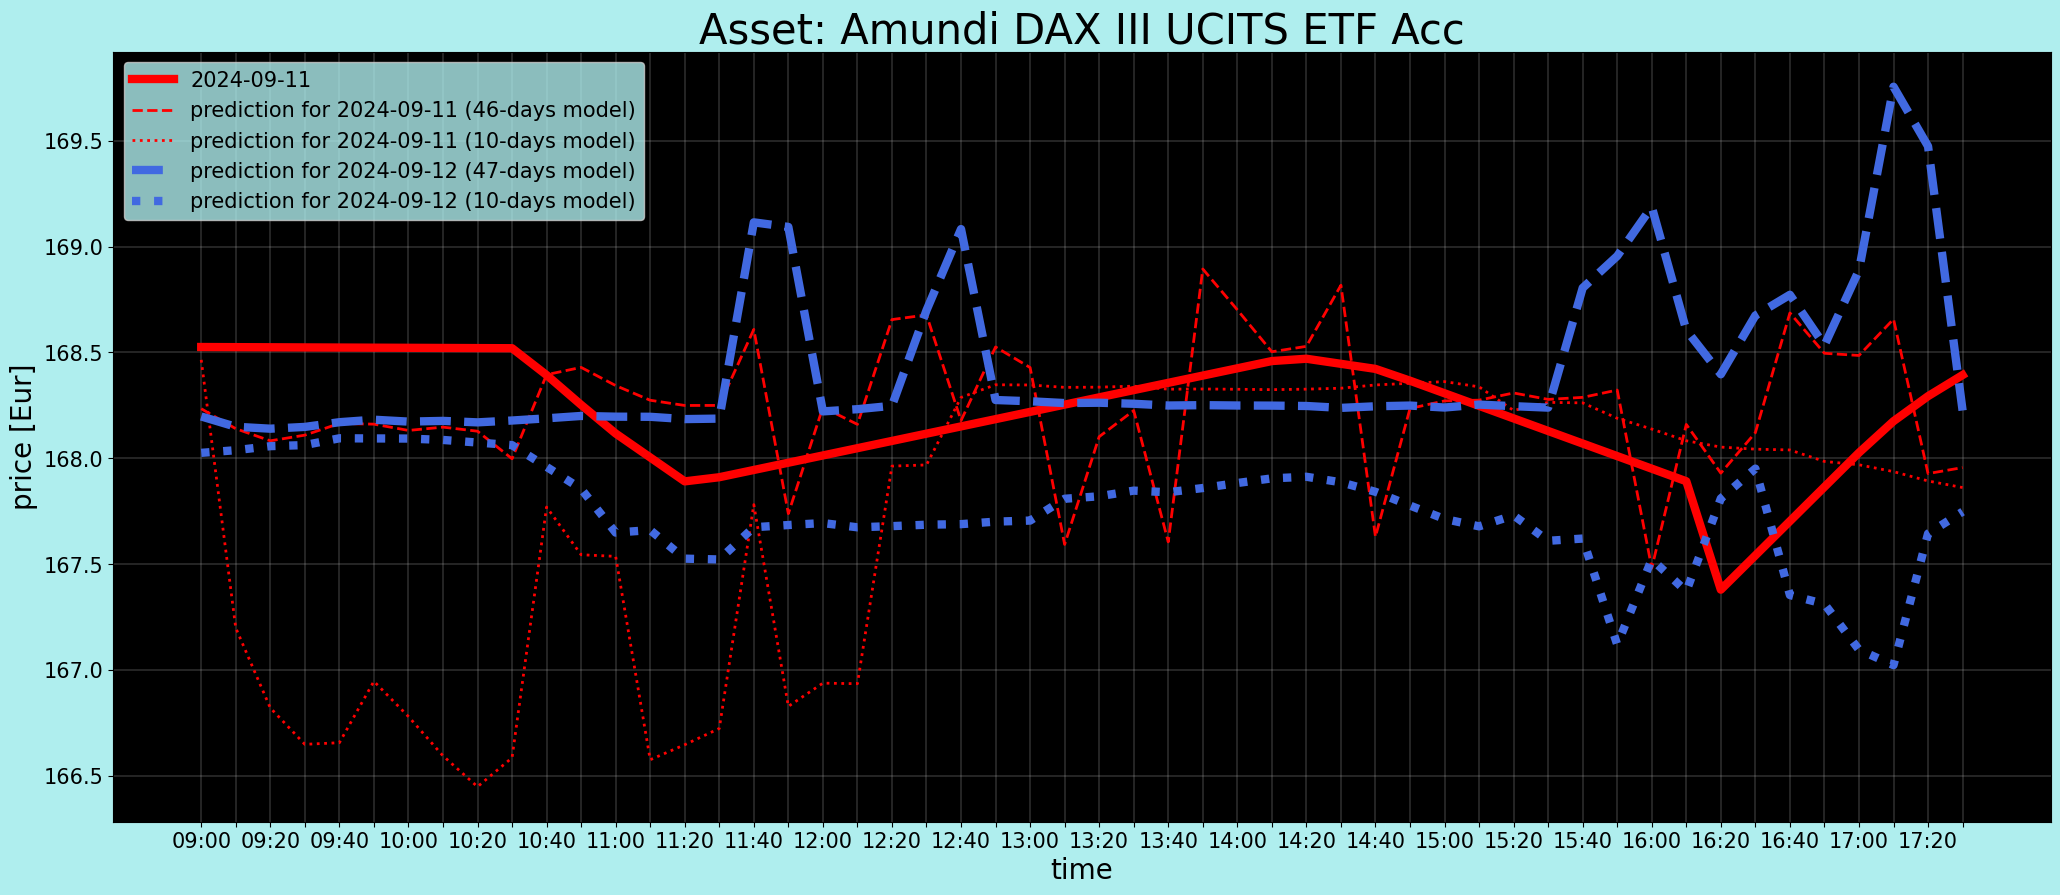

In [26]:
# plot lines covering the actual line, its 10 day as well as l-1-day prediction, with l=X.shape[0]
# in addition the 10 day l-day prediction for the next working day are shown

fig = plt.figure(figsize=(25, 10), facecolor='paleturquoise',edgecolor='red')
plt.plot(df.index,df.iloc[:,0],  label = df.columns[0],linestyle="solid", color='red',linewidth=6)
plt.plot(df.index,df.iloc[:,1],  label = df.columns[1],linestyle="dashed", color='red',linewidth=2)
plt.plot(df.index,df.iloc[:,2],  label = df.columns[2],linestyle="dotted", color='red',linewidth=2)
plt.plot(df.index,df.iloc[:,3],  label = df.columns[3],linestyle="dashed", color='royalblue',linewidth=6)
plt.plot(df.index,df.iloc[:,4],  label = df.columns[4],linestyle="dotted", color='royalblue',linewidth=6)

plt.xlabel("time",fontsize=20)
plt.ylabel("price [Eur]",fontsize=20)
plt.grid(lw=0.3)
plt.title("Asset: " + lastfilename.split("_")[1][:-4],fontsize=30)
plt.gca().axes.set_facecolor('xkcd:black')
plt.tick_params(axis='x', which='major', labelsize=15)
plt.tick_params(axis='y', which='major', labelsize=15)
for label in plt.gca().xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
plt.legend(fontsize=15, facecolor='paleturquoise')
plt.show()



### 6 Export prognosis

In [27]:
# output_df=pd.DataFrame(pd.concat([ pd.DataFrame(course_next_day.T.index.values,columns=['clock_time']), pd.DataFrame([i for i in times_of_interest],columns=["time"]),pd.DataFrame(course_next_day.T.values,columns=['course'])],axis=1))
# output_df.to_csv('prognosis.csv', index=False)